In [1]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### (a) Plot the training and validation losses and errors as a function of the number of epochs


 The model currently does not achieve less than 12% validation error, you have to tweak the parameters to get it.

In [2]:
# Reading in the dataset
transform = transforms.Compose(
    [transforms.RandAugment(), transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# The training loop
def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [40, 80, epochs-20], gamma = 0.1, verbose=True)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        if epoch == 25 and flag == 0:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.001
          flag = 1
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device).to(torch.float16)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              # for tag, value in info.items():
              #   logger.scalar_summary(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)
        # scheduler.step()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device).to(torch.float16)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values


In [4]:
model = allcnn_t().to(device).to(torch.float16)
# model = torch.compile(model)
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.00001, nesterov=True)

Num parameters:  1667166


## Using Rand Augment

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


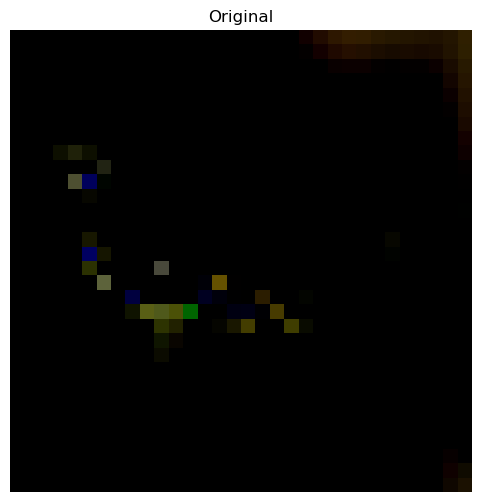

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


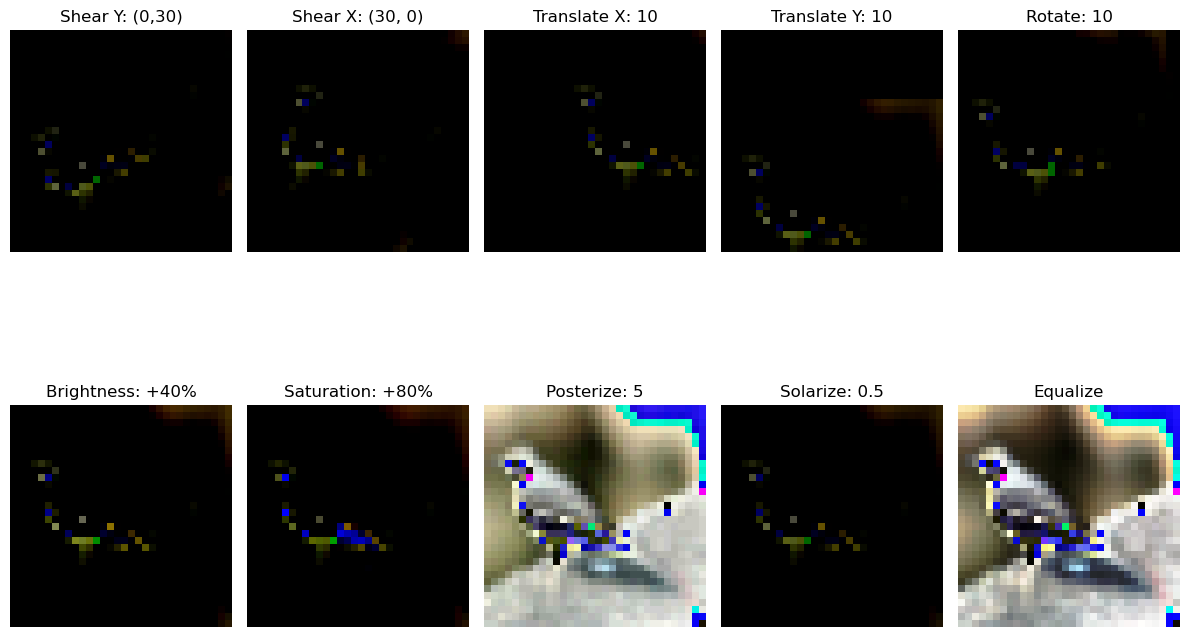

In [5]:
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import torch
import matplotlib.pyplot as plt

# Load an example image
image = None
for i, (images, labels) in enumerate(trainloader):
    image = images[3].detach().cpu()
    break

# Display the original image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(image.permute(1, 2, 0))  # Transpose the dimensions
ax.set_title("Original")
ax.axis('off')
plt.savefig('Original image.png')
plt.show()

# Define a list of transformations
titles = ['Shear Y: (0,30)', 'Shear X: (30, 0)', 'Translate X: 10', 
          'Translate Y: 10', 'Rotate: 10', 'Brightness: +40%', 'Saturation: +80%', 'Posterize: 5', 'Solarize: 0.5', 'Equalize']
transformations = [
    F.affine(image, angle = 0, translate=[0,0], scale = 1.0,shear = (0,30), fill = 0),
    F.affine(image, angle = 0,  translate=[0,0], scale = 1.0, shear = (30,0), fill = 0),
    F.affine(image, angle =0, translate = [10, 0], scale = 1.0, shear=[0, 0]), 
    F.affine(image, angle=0,translate =[0,10], scale=1.0, shear=[0,0]), 
    F.rotate(image, angle = 10, fill = 0),
    F.adjust_brightness(image, brightness_factor=1.4),
    F.adjust_saturation(image, saturation_factor=1.8),
    F.posterize((image*255).to(dtype = torch.uint8), bits = 5),
    F.solarize(image, threshold=0.5),
    F.equalize((image*255).to(dtype = torch.uint8))
]

# Create a subplot to display the original and augmented images
num_rows = 2
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))
axes = axes.ravel()
axes[0].imshow(image.permute(1, 2, 0))
axes[0].set_title("Original")

# Apply the augmentations and display the results
for i, transform in enumerate(transformations):
    augmented_image = transform.numpy().transpose((1,2,0))
    axes[i].imshow(augmented_image)
    axes[i].set_title(titles[i])

# Remove axis labels
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.savefig('Augmentations.png')
plt.show()


In [6]:
val_error,val_loss_values,train_error,train_loss_values= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Epoch [1/10], Step [1000/3125], Loss: 2.0176
Epoch [1/10], Step [2000/3125], Loss: 1.9209
Epoch [1/10], Step [3000/3125], Loss: 1.8828
Accuracy of the network on the test images: 43.48 %
Epoch [2/10], Step [1000/3125], Loss: 1.3604
Epoch [2/10], Step [2000/3125], Loss: 1.2090
Epoch [2/10], Step [3000/3125], Loss: 1.0293
Accuracy of the network on the test images: 60.48 %
Epoch [3/10], Step [1000/3125], Loss: 0.8457
Epoch [3/10], Step [2000/3125], Loss: 1.4092
Epoch [3/10], Step [3000/3125], Loss: 0.8745
Accuracy of the network on the test images: 66.1 %
Epoch [4/10], Step [1000/3125], Loss: 0.6924
Epoch [4/10], Step [2000/3125], Loss: 1.1660
Epoch [4/10], Step [3000/3125], Loss: 1.0205
Accuracy of the network on the test images: 70.35 %
Epoch [5/10], Step [1000/3125], Loss: 0.7373
Epoch [5/10], Step [2000/3125], Loss: 0.7402
Epoch [5/10], Step [3000/3125], Loss: 0.7534
Accuracy of the network on the test images: 72.41 %
Epoch [6/10], Step [1000/3125], Loss: 0.8989
Epoch [6/10], Step [2

In [7]:
torch.save(model.state_dict(), './model.pth')

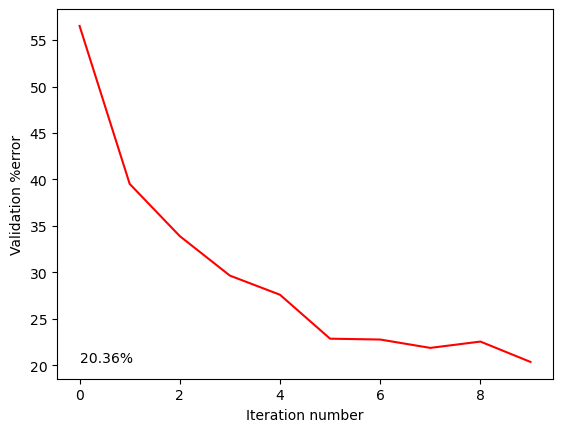

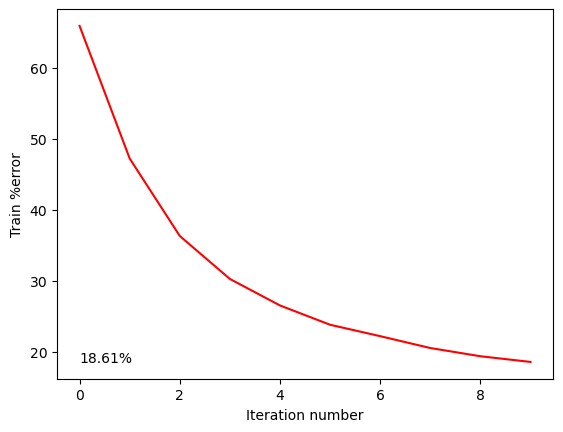

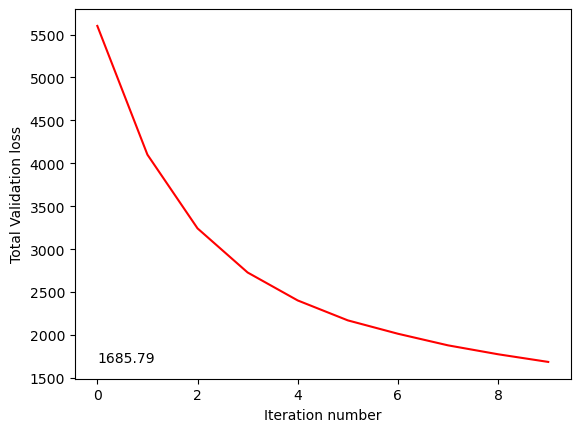

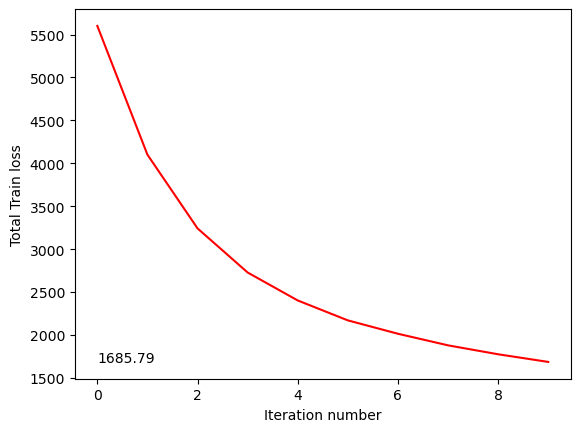

In [8]:
plt.plot(val_error, 'r')
plt.xlabel('Iteration number')
plt.ylabel('Validation %error')
plt.text(len(val_error)-10, val_error[-1], f'{val_error[-1]:.2f}%')
plt.savefig('Validation Error.png')
plt.show()

plt.plot(train_error, 'r')
plt.xlabel('Iteration number')
plt.ylabel('Train %error')
plt.text(len(train_error)-10, train_error[-1], f'{train_error[-1]:.2f}%')
plt.savefig('Train Error.png')
plt.show()

plt.plot(val_loss_values, 'r')
plt.xlabel('Iteration number')
plt.ylabel('Total Validation loss')
plt.text(len(val_loss_values)-10, val_loss_values[-1], f'{val_loss_values[-1]:.2f}')
plt.savefig('ValidationLoss.png')
plt.show()

plt.plot(train_loss_values, 'r')
plt.xlabel('Iteration number')
plt.ylabel('Total Train loss')
plt.text(len(train_loss_values)-10, train_loss_values[-1], f'{train_loss_values[-1]:.2f}')
plt.savefig('TrainLoss.png')
plt.show()

## Plotting Gradients for the the images

In [9]:
model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

In [10]:
testloader = torch.utils.data.DataLoader(testset, batch_size =1, shuffle = False)
model.eval()
correct_images = []
incorrect_images = []

for i , (images, labels) in enumerate(testloader):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    results = model(images)
    loss = criterion(results, labels)
    optimizer.zero_grad()
    loss.backward()

    dx = images.grad.data.clone().to('cpu').detach().numpy()[0]

    if torch.argmax(results).item() == labels.item() and len(correct_images)<5:
        correct_images.append((images, dx))
    elif len(incorrect_images)<5:
        incorrect_images.append((images, dx))
    else:
        break
    


RuntimeError: Input type (float) and bias type (c10::Half) should be the same

In [ ]:
len(correct_images), len(incorrect_images)

In [ ]:
fig, axes = plt.subplots(5, 5, figsize = (15, 15.5))
for i, (images, dx) in enumerate(correct_images):
    # dx = dx.detach().cpu().numpy()[0]
    axes[i, 0].imshow(images[0].detach().to('cpu').numpy().transpose((1,2,0)))
    axes[i, 0].set_title('Image')
    axes[i,1].imshow(dx[0], cmap = 'Reds')
    axes[i,1].set_title('Gradient Red Channel')
    axes[i,2].imshow(dx[1], cmap = 'Greens')
    axes[i,2].set_title('Gradient Green Channel')
    axes[i,3].imshow(dx[2], cmap = 'Blues')
    axes[i,3].set_title('Gradient Blue Channel')
    axes[i,4].imshow(np.linalg.norm(dx, ord = 2, axis = 0), cmap = 'gray')
    axes[i,4].set_title('Gradient Vector Sum')
plt.suptitle('Correctly Classified Images')
plt.subplots_adjust()
plt.savefig('CorrectGrad.png')
plt.show()


In [ ]:
fig, axes = plt.subplots(5, 5, figsize = (15, 15.5))
for i, (images, dx) in enumerate(incorrect_images):
    # dx = dx[0].detach().cpu().numpy()
    axes[i, 0].imshow(images[0].detach().to('cpu').numpy().transpose((1,2,0)))
    axes[i, 0].set_title('Image')
    axes[i,1].imshow(dx[0], cmap = 'Reds')
    axes[i,1].set_title('Gradient Red Channel')
    axes[i,2].imshow(dx[1], cmap = 'Greens')
    axes[i,2].set_title('Gradient Green Channel')
    axes[i,3].imshow(dx[2], cmap = 'Blues')
    axes[i,3].set_title('Gradient Blue Channel')
    axes[i,4].imshow(np.linalg.norm(dx, ord = 2, axis = 0), cmap = 'gray')
    axes[i,4].set_title('Gradient Vector Sum')
plt.suptitle('Incorrectly Classified Images')
plt.subplots_adjust()
plt.savefig('IncorrectGrad.png')
plt.show()

## Perturbing Images

In [ ]:
toperturbImages = None
correspondingLabels = None
temploader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True)
for i, (images, labels) in enumerate(temploader):
    toperturbImages = images
    correspondingLabels = labels
    break

print(len(toperturbImages), len(correspondingLabels))

In [ ]:
PertubationNumber = 5
model.eval()
losses = []
eps = 8
toperturbImages =toperturbImages.to(device)
correspondingLabels = correspondingLabels.to(device)

for i in range(PertubationNumber):
    l = 0
    for j in range(len(toperturbImages)):
        image = toperturbImages[j].unsqueeze(0).to(device)
        label = correspondingLabels[j].unsqueeze(0).to(device)
        image = torch.autograd.Variable(image)
        image.requires_grad = True
        result = model(image)
        loss = criterion(result, label)
        optimizer.zero_grad()
        loss.backward()
        dx = image.grad.data.clone()
        image = image + eps*torch.sign(dx)
        toperturbImages[j] = image[0]
        l+= loss.item()
    losses.append(l/100)




In [ ]:
fig = plt.figure()
plt.plot(losses)
plt.plot(losses, '.r')
plt.xlabel('# of perturbations')
plt.ylabel('Loss for 16 images')
plt.savefig('LossVPerturb.png')
plt.show()

## Impact on one-step perturbation

In [ ]:
eps = 8
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

model.eval()

correct = 0
correct_perturb = 0
total = 0
for i, (images, labels) in enumerate(testloader):
    images = images.to(device)
    labels = labels.to(device)
    images = torch.autograd.Variable(images)
    # labels = torch.autograd.Variable(labels)
    images.requires_grad = True
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    dx = images.grad.data.clone()
    images = images+(eps/255)*torch.sign(dx)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    correct_perturb += (predicted == labels).sum().item()



print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
print('Accuracy of the network on the test images: {} %'.format(100*correct_perturb/total))